# Operationalizing an AWS ML project 

## SageMaker

### Selecting the right instance type for notebook
I decide to just go with the default instance type, namely ml.t3.medium. The notebook itself is doing very little, just coordinating the different tasks, such as initiating hyperparameter tuning, training and deployment. These activities themselves are happening on other instances. 


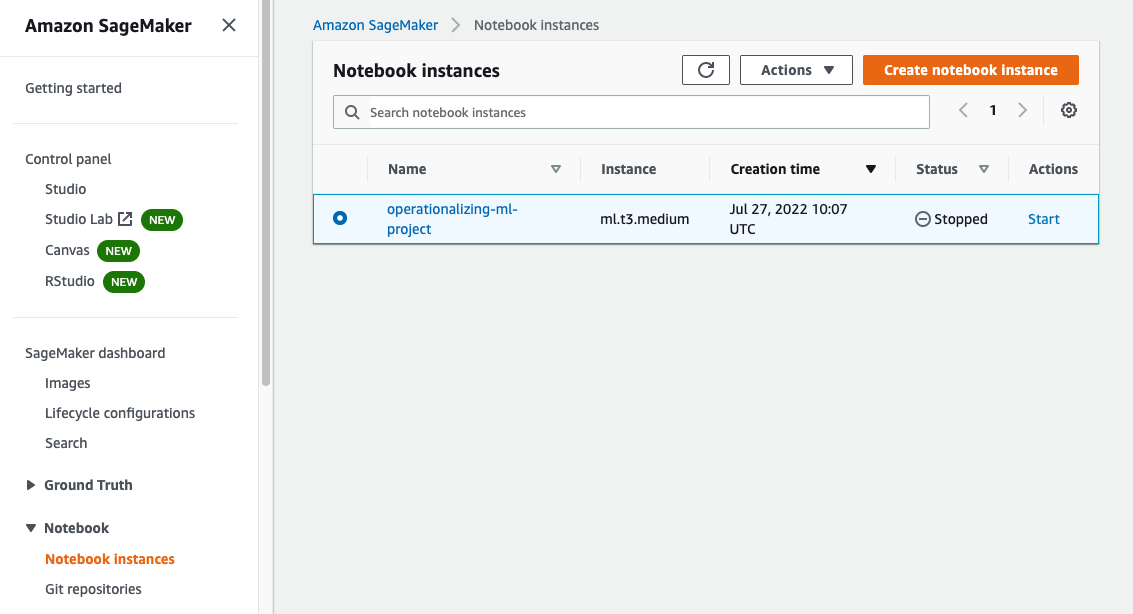

In [28]:
from IPython import display
display.Image("./screenshots/sagemaker-notebook-instance.png")

## Getting data
I modified the notebook slightly so rather than just having commands that blindly download the data and then upload to S3 I've created a couple of functions that will check if the data has already been downloaded before downloading and check if it exists on S3 before uploading. This will avoid unneccessary downloads and uploads.

```
def download_dog_images():
    # check if not already downloaded
    data_folder='dogImages'
    dpath = f"data/{data_folder}"
    if path.exists(dpath):
        print('data already downloaded return path')
        return dpath
    !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
    !unzip dogImages.zip
    !mv dogImages data/
    return dpath
    
# Command to download and unzip data
def get_s3_data_url(bucket=bucket, prefix=prefix, data_folder='dogImages'):
    print('get_data_url', bucket, prefix, data_folder)
    result = s3.list_objects_v2(Bucket=bucket, Prefix=f'{prefix}/{data_folder}')
    if 'Contents' in result:
        print('folder already exists so don\'t need to upload')
        url = f's3://{bucket}/{prefix}/{data_folder}'
    else:
        url = sagemaker_session.upload_data(path=f'data/{data_folder}', bucket=bucket, key_prefix=f'{prefix}/{data_folder}')

    print("S3 path): {}".format(url))
    return url
```

I'm storing the data in the default sagemaker bucket as shown by the image below

As a side point, although I often prefer to run notebooks locally, when transferring data to S3 this is quicker if done via a sagemaker hosted instance.

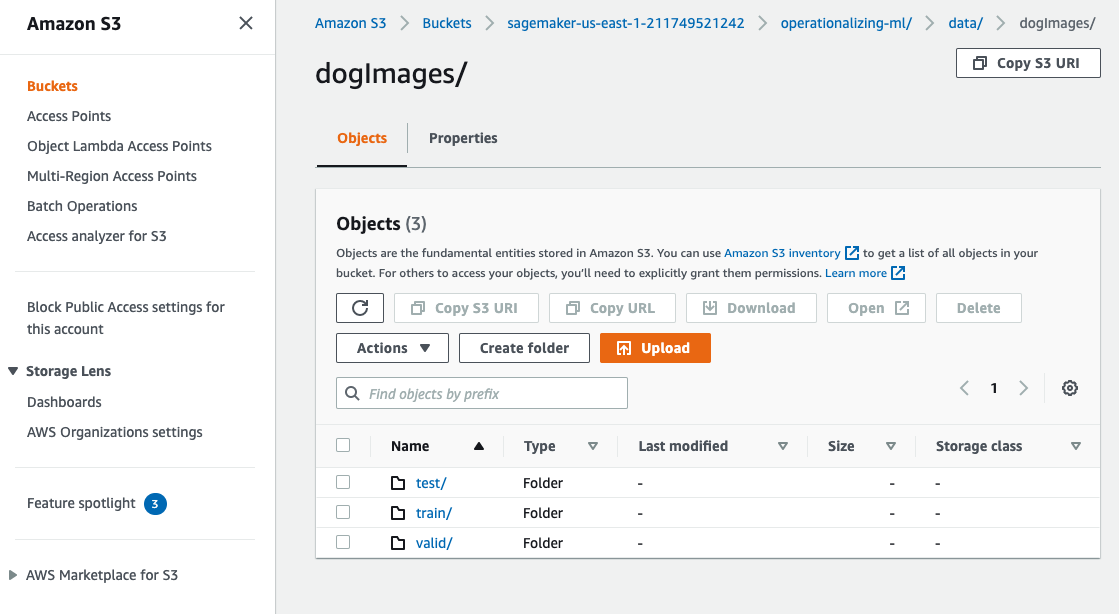

In [8]:
from IPython import display
display.Image("./screenshots/s3-uploaded-files.png")

## SageMaker training and deployment

### Hyperparmeter tuning
A Hyperparameter Tuner is defined to determine the most suitable values for two hyperparameters, namely:
- learning rate
- batch size

With these hyperparameters tuned a single instance was used for training

### Deployed endpoint
Having trained the model, it's deployed as can be seen from the image below.


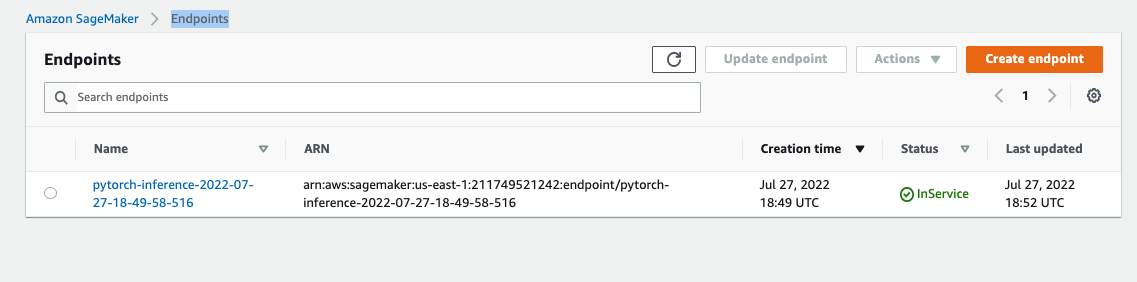

In [29]:
from IPython import display
display.Image("./screenshots/sagemaker-deployed-endpoint.png")

### Multi-instance training

The solution was then altered to perform the training on multiple instances, I chose 5 instance largely because this is not an unusual number of instances to use, so seemed like a choice.
This was achieved by setting the instance_count to 5 when creating the estimator

```
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=5,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

```

The fit method was run, waiting for the results

```
estimator.fit({"training": s3_data_url}, wait=False)

```

## Using EC2

In order to set up the EC2 instance for training the instructions suggest copying and pasting the code from ec2train1.py into solution.py, rather than doing this I created a git repository, hosted in github with the required code in solution.py and cloned this repo on to the Ec2 instance.

When using EC2 instances rather than SageMaker the training happens on the EC2 instance so it would seem sensible to use the same instance type as used in training with SageMaker, namely an m5.xlarge. 

Using SageMaker the training on the same instance type took 30 minutes for 50 epochs, compared to 3 minutes (188 seconds) for 5 epochs, so these are broadly inline.

- AMI: Deep Learning AMI GPU PyTorch 1.12.0 (Amazon Linux 2) 20220727
ami-012fb2e1c5d400f97
- instance type: m5.xlarge (4 CPU 16 GB)
- training duration:  188 seconds

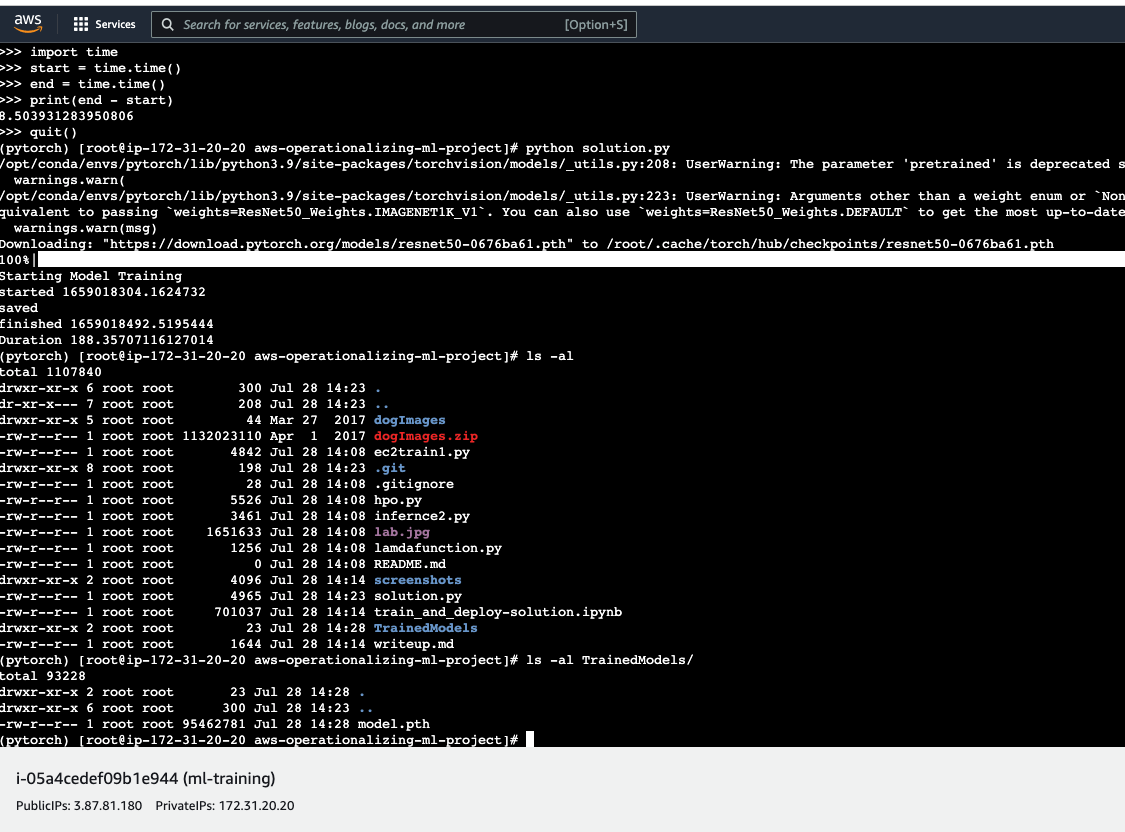

In [31]:
from IPython import display
display.Image("./screenshots/ec2-based-model-training-m5-xlarge.png")

I also experimented with an alternate instance to if this was different. I chose an ARM bassed instance with 8 CPUs and 16GB of memory (c6g.2xlarge). This instance was slower at over 8 and half minutes (519 seconds).

- AMI: NVIDIA GPU-Optimized ARM64 22.06.0-8c85b20b-d7b9-4aa6-8d9c-584018f77e4e
ami-0126d561b2bb55618
- instance type: c6g.2xlarge (8 CPU 16GB)
- training duration: 519 seconds

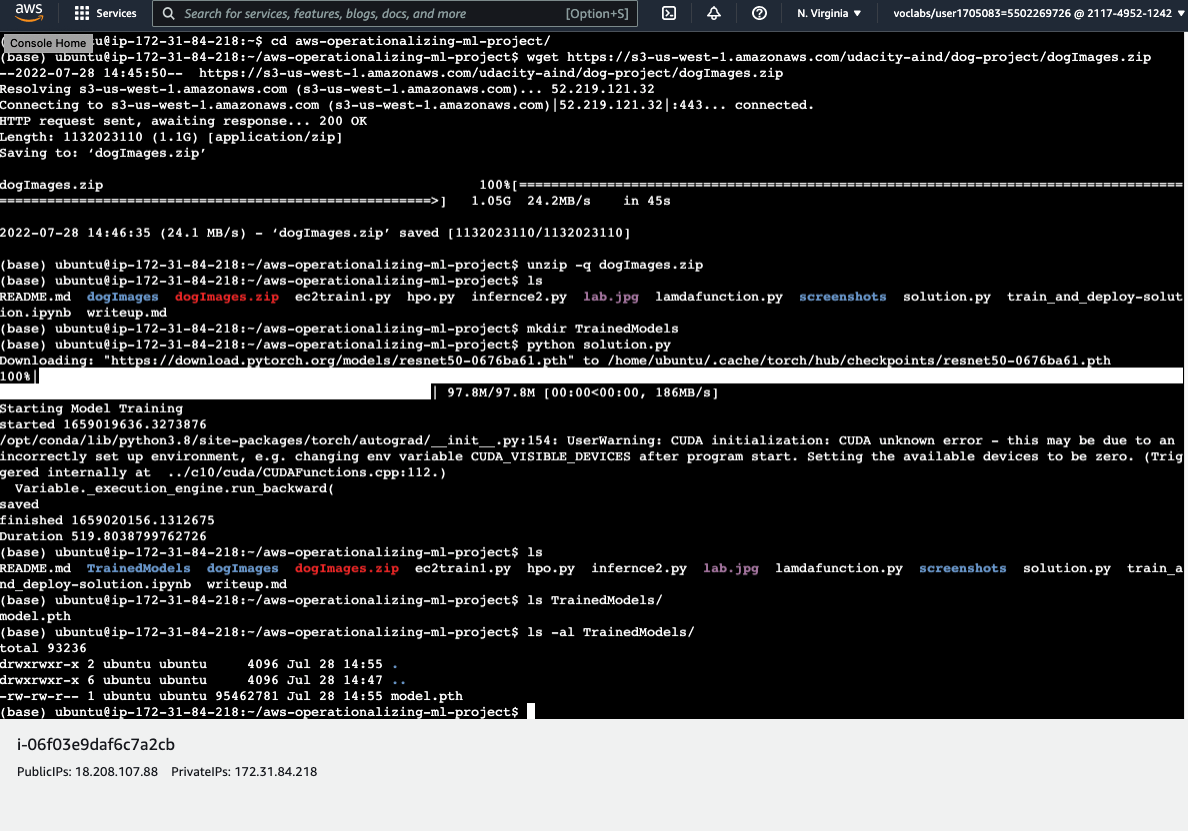

In [32]:
from IPython import display
display.Image("./screenshots/ec2-based-model-training-arm-c6g.2xlarge.png")

### Comparison between EC2 code (solution.py) and code for step 1
The code for step 1 is made up of the jupyter notebook (train_and_deploy-solution.ipynb) and the script hpo.py

The notebook uses SageMaker classes and functions to run the training, whereas the EC2 code does not use SageMaker. The step 1 code relies on the use of SageMaker contrainers which are used to run the hpo.py script. The container ensures that environment variables are defined that can be accessed from the script, such as SM_CHANNEL_TRAINING and SM_MODEL_DIR.

For both solutions the training assumes that the training and test data is stored locally, but for the SageMaker based solution that data is automatically downloaded from S3 to the SageMaker container and when the training is completed the model is uploaded to S3. For the EC2 solution the training and test data needs to be eplicitly downloaded to the instance and the model (model.pth) is not uploaded to S3, so would need to be explicitly done is this was required.

Although not relevant to the fact that solution.py is running on the EC2 instance and hpo.py running in a SageMaker container, the hpo.py version trains for 50 epochs, whereas solution.py only runs for 5 epochs.

## Lambda function

### Description
The lambda function invokes the deployed endpoint with the provided image request.

The request, which is defined in the event parameter, is a python dict, containing a key, 'url' which points to the image that a prediction is required. 

The request, which is converted to a string (using json.dumps) is passed to the endpoint, so that it can make a predition (runtime.invoke_endpoint)

The respone is a dict with the actual result in the 'Body' key. This is a json string in utf8 format that is decoded and parsed into a dict (json.loads). Noting is done to this dict other that return it, as a string.

### Result of running test

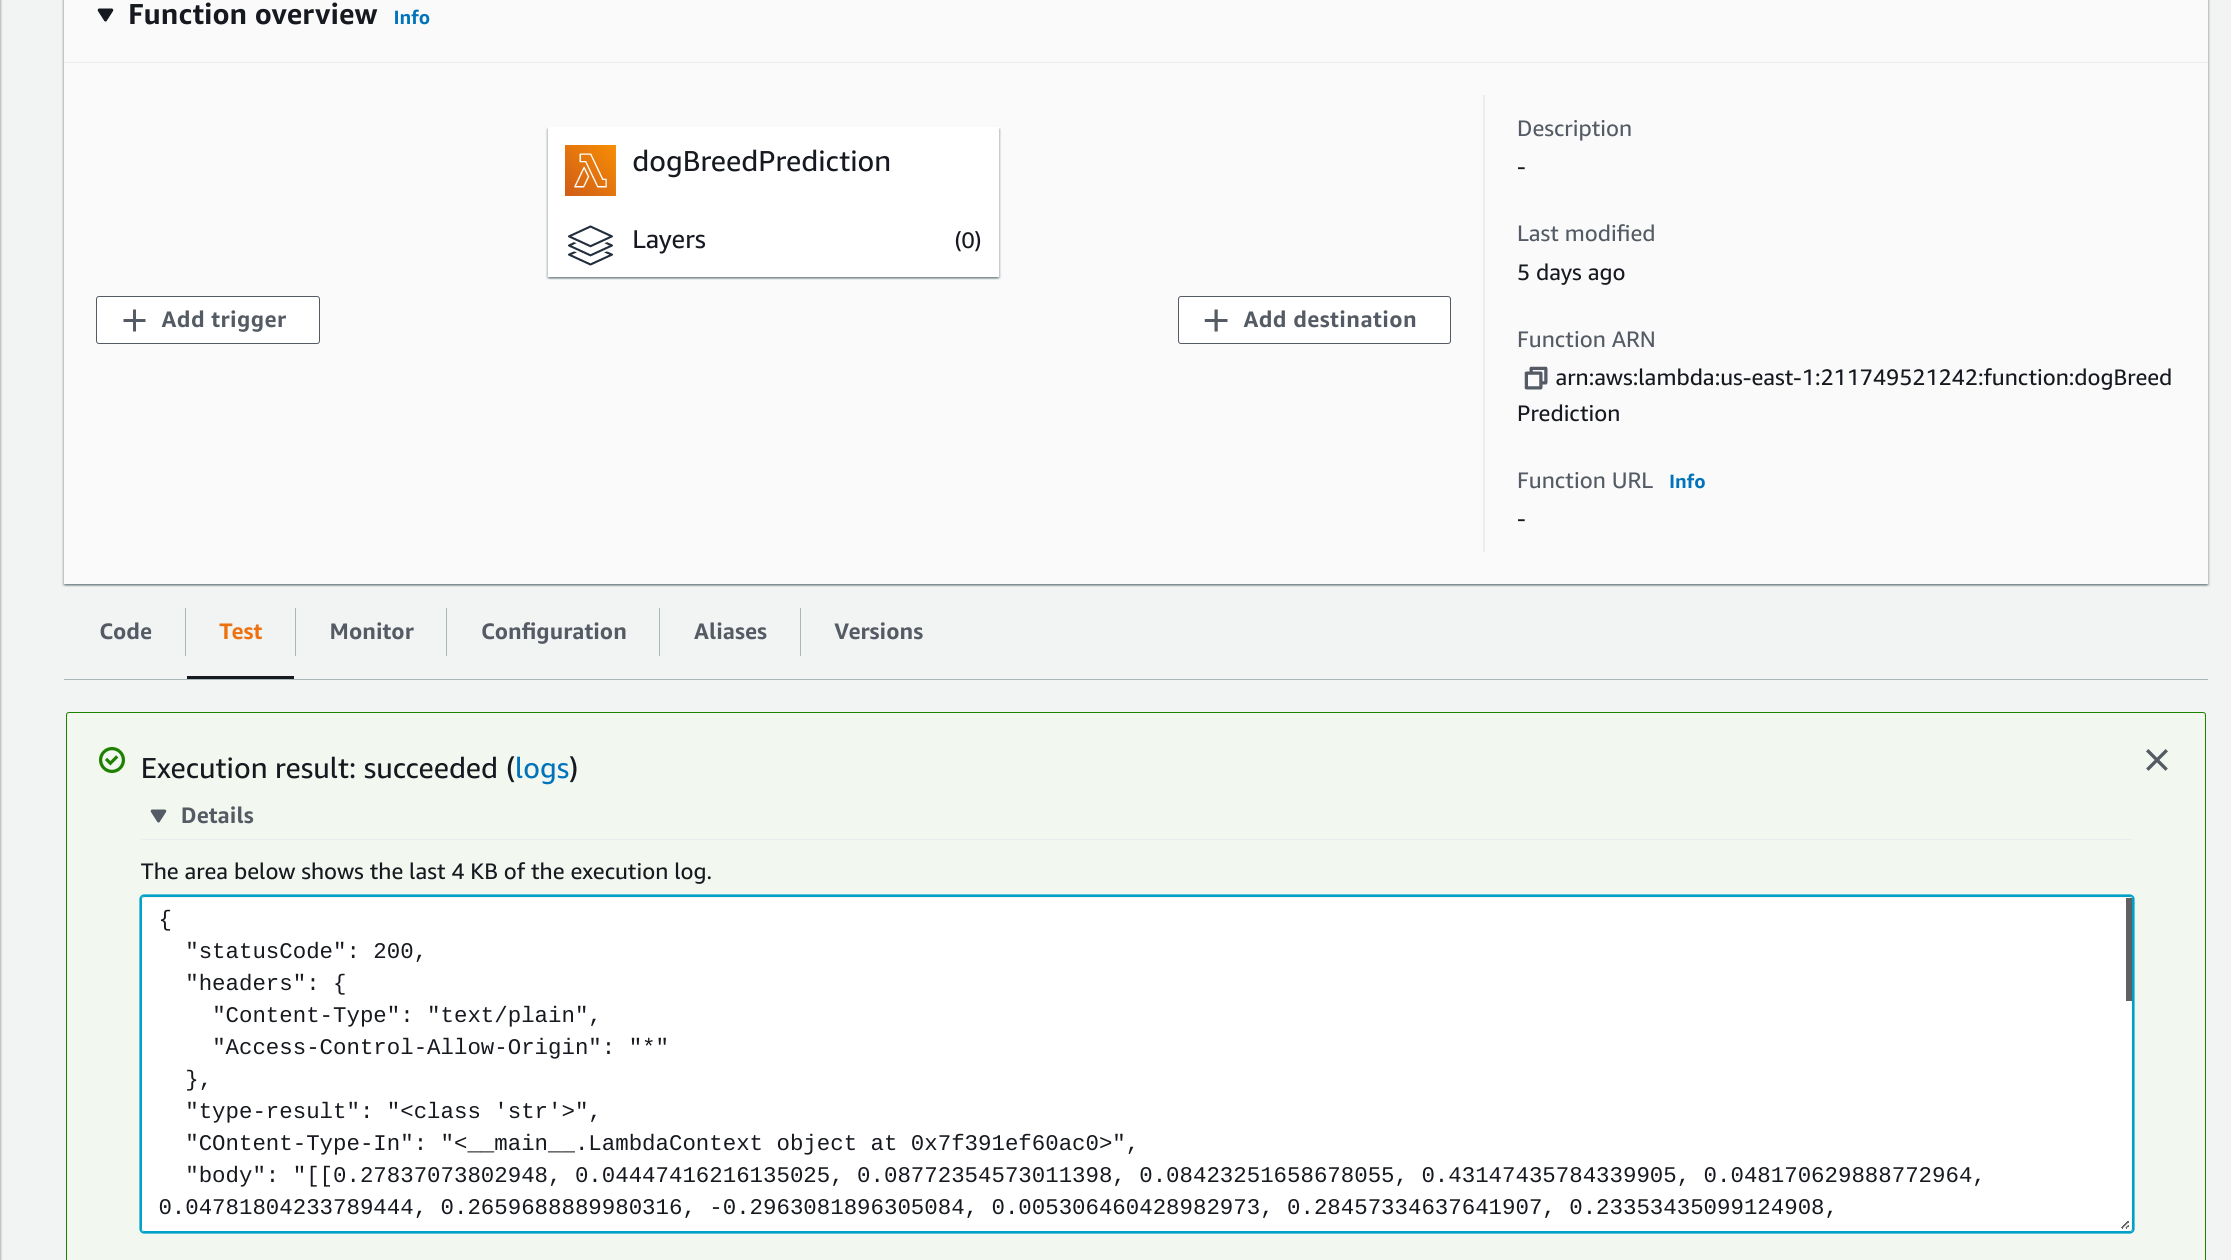

In [34]:
from IPython import display
display.Image("./screenshots/lambda-invoke-summary.png")

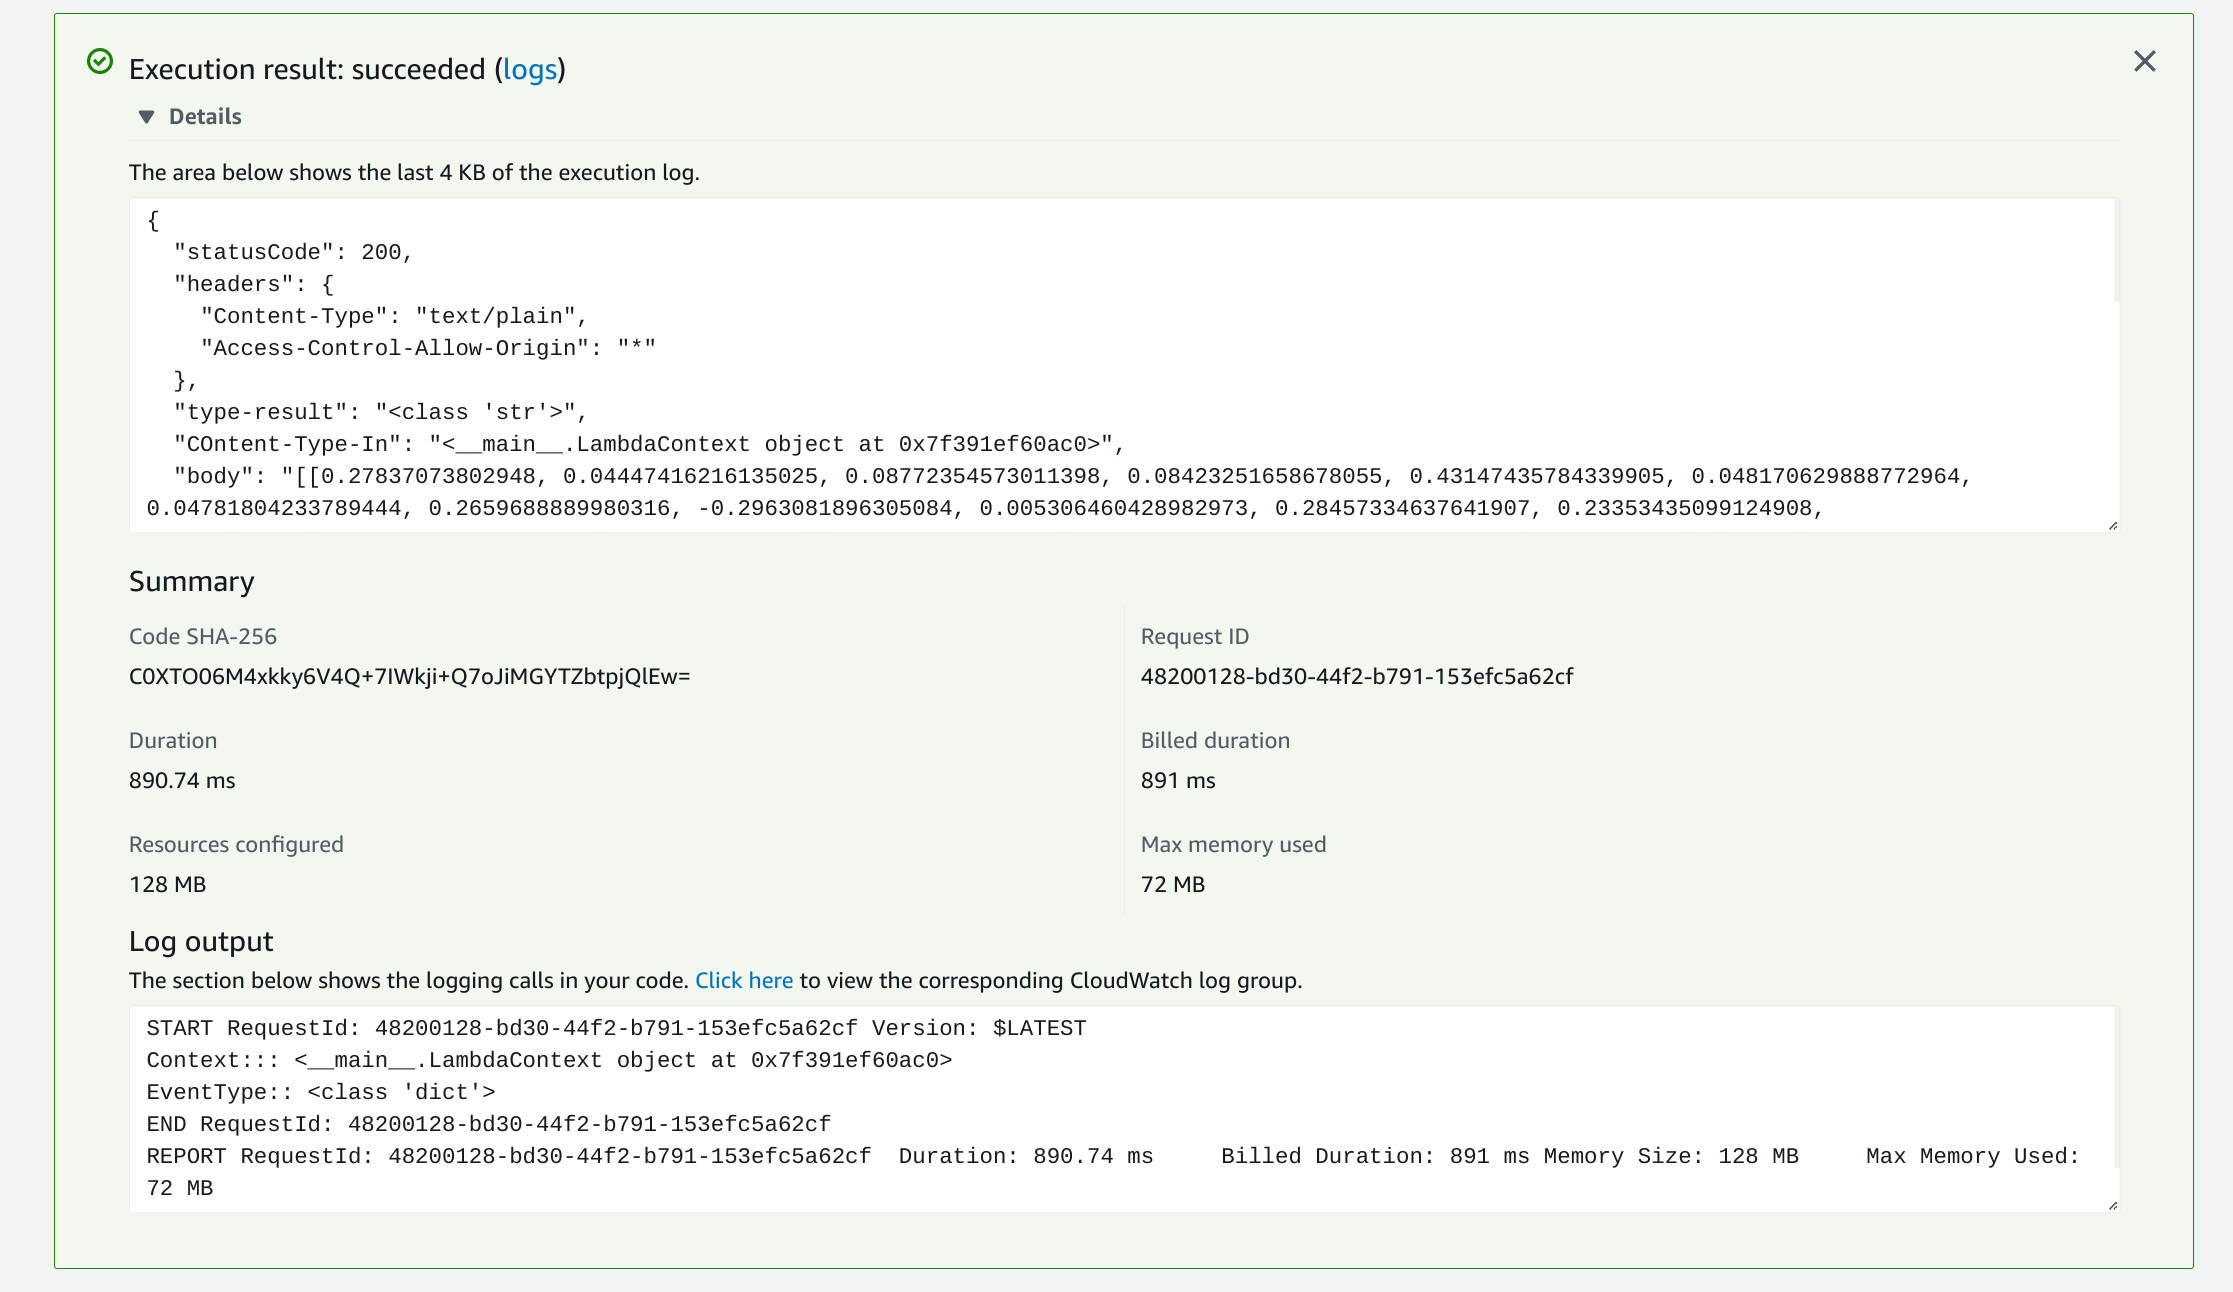

In [33]:
from IPython import display
display.Image("./screenshots/lambda-invoke-result.png")

In [22]:
result = {
  "statusCode": 200,
  "headers": {
    "Content-Type": "text/plain",
    "Access-Control-Allow-Origin": "*"
  },
  "type-result": "<class 'str'>",
  "COntent-Type-In": "<__main__.LambdaContext object at 0x7f391ef60ac0>",
  "body": "[[0.27837073802948, 0.04447416216135025, 0.08772354573011398, 0.08423251658678055, 0.43147435784339905, 0.048170629888772964, 0.04781804233789444, 0.2659688889980316, -0.2963081896305084, 0.005306460428982973, 0.28457334637641907, 0.23353435099124908, -0.03939438983798027, 0.2339235246181488, 0.29771310091018677, 0.1345776617527008, 0.17139646410942078, 0.12493347376585007, 0.09417985379695892, 0.2271737903356552, -0.07736297696828842, 0.03855154663324356, 0.22199372947216034, 0.19786876440048218, -0.17536139488220215, -0.10673035681247711, 0.27649247646331787, -0.14385995268821716, 0.29554420709609985, -0.020497672259807587, 0.06791572272777557, 0.3133232295513153, -0.09704633057117462, 0.2850247025489807, 0.08604960888624191, 0.3048481047153473, 0.09074036031961441, 0.10789710283279419, 0.3430626690387726, 0.10530168563127518, 0.2904141843318939, 0.22709132730960846, 0.02540629915893078, 0.21565790474414825, 0.02649211511015892, 0.3117626905441284, 0.17888249456882477, 0.055942416191101074, -0.036116503179073334, 0.02652520127594471, 0.23381799459457397, -0.017467139288783073, 0.0575285367667675, 0.04012781381607056, 0.08185013383626938, 0.2719041705131531, 0.35384753346443176, 0.11108745634555817, 0.03567246347665787, 0.1983032524585724, 0.22811968624591827, 0.04521993547677994, 0.12664005160331726, -0.12696991860866547, -0.04820912703871727, -0.2267991602420807, -0.19890928268432617, 0.2241082638502121, 0.0258253775537014, 0.06148441880941391, 0.0075848763808608055, -0.12573660910129547, -0.09644808620214462, -0.09672113507986069, -0.06533775478601456, 0.21906757354736328, -0.10259288549423218, -0.09746284782886505, 0.09612710028886795, -0.017138104885816574, 0.12867918610572815, 0.2206484079360962, -0.043215349316596985, -0.051485687494277954, -0.16690415143966675, 0.07958080619573593, 0.3204757571220398, 0.13599102199077606, 0.10445240885019302, 0.2073504477739334, 0.10660405457019806, -0.06681709736585617, -0.22584757208824158, -0.04944225773215294, -0.062499336898326874, 0.005806705914437771, 0.05131521448493004, 0.01224043034017086, -0.01567743718624115, -0.19582846760749817, 0.0035316720604896545, -0.31438514590263367, 0.20527315139770508, -0.10403906553983688, -0.3009165823459625, 0.02926318347454071, -0.06913899630308151, -0.3996356725692749, -0.09260242432355881, -0.2510949671268463, -0.05806760489940643, 0.06912057846784592, -0.14463822543621063, -0.15559682250022888, -0.16358083486557007, -0.3511332869529724, -0.03164283186197281, 0.05595657229423523, -0.30750563740730286, -0.12930366396903992, -0.34282153844833374, -0.2820359170436859, -0.26111316680908203, 0.04039888456463814, -0.23247259855270386, -0.23115381598472595, -0.1269843578338623, -0.2949020266532898, -0.006460410542786121, -0.016129150986671448, -0.27785953879356384, -0.43078741431236267, -0.3330926299095154]]"
}

print(json.dumps(json.loads(result['body'])[0], indent=2))

[
  0.27837073802948,
  0.04447416216135025,
  0.08772354573011398,
  0.08423251658678055,
  0.43147435784339905,
  0.048170629888772964,
  0.04781804233789444,
  0.2659688889980316,
  -0.2963081896305084,
  0.005306460428982973,
  0.28457334637641907,
  0.23353435099124908,
  -0.03939438983798027,
  0.2339235246181488,
  0.29771310091018677,
  0.1345776617527008,
  0.17139646410942078,
  0.12493347376585007,
  0.09417985379695892,
  0.2271737903356552,
  -0.07736297696828842,
  0.03855154663324356,
  0.22199372947216034,
  0.19786876440048218,
  -0.17536139488220215,
  -0.10673035681247711,
  0.27649247646331787,
  -0.14385995268821716,
  0.29554420709609985,
  -0.020497672259807587,
  0.06791572272777557,
  0.3133232295513153,
  -0.09704633057117462,
  0.2850247025489807,
  0.08604960888624191,
  0.3048481047153473,
  0.09074036031961441,
  0.10789710283279419,
  0.3430626690387726,
  0.10530168563127518,
  0.2904141843318939,
  0.22709132730960846,
  0.02540629915893078,
  0.2156579

### Defining the right policy

#### IAM Dashboard of Lambda execution role

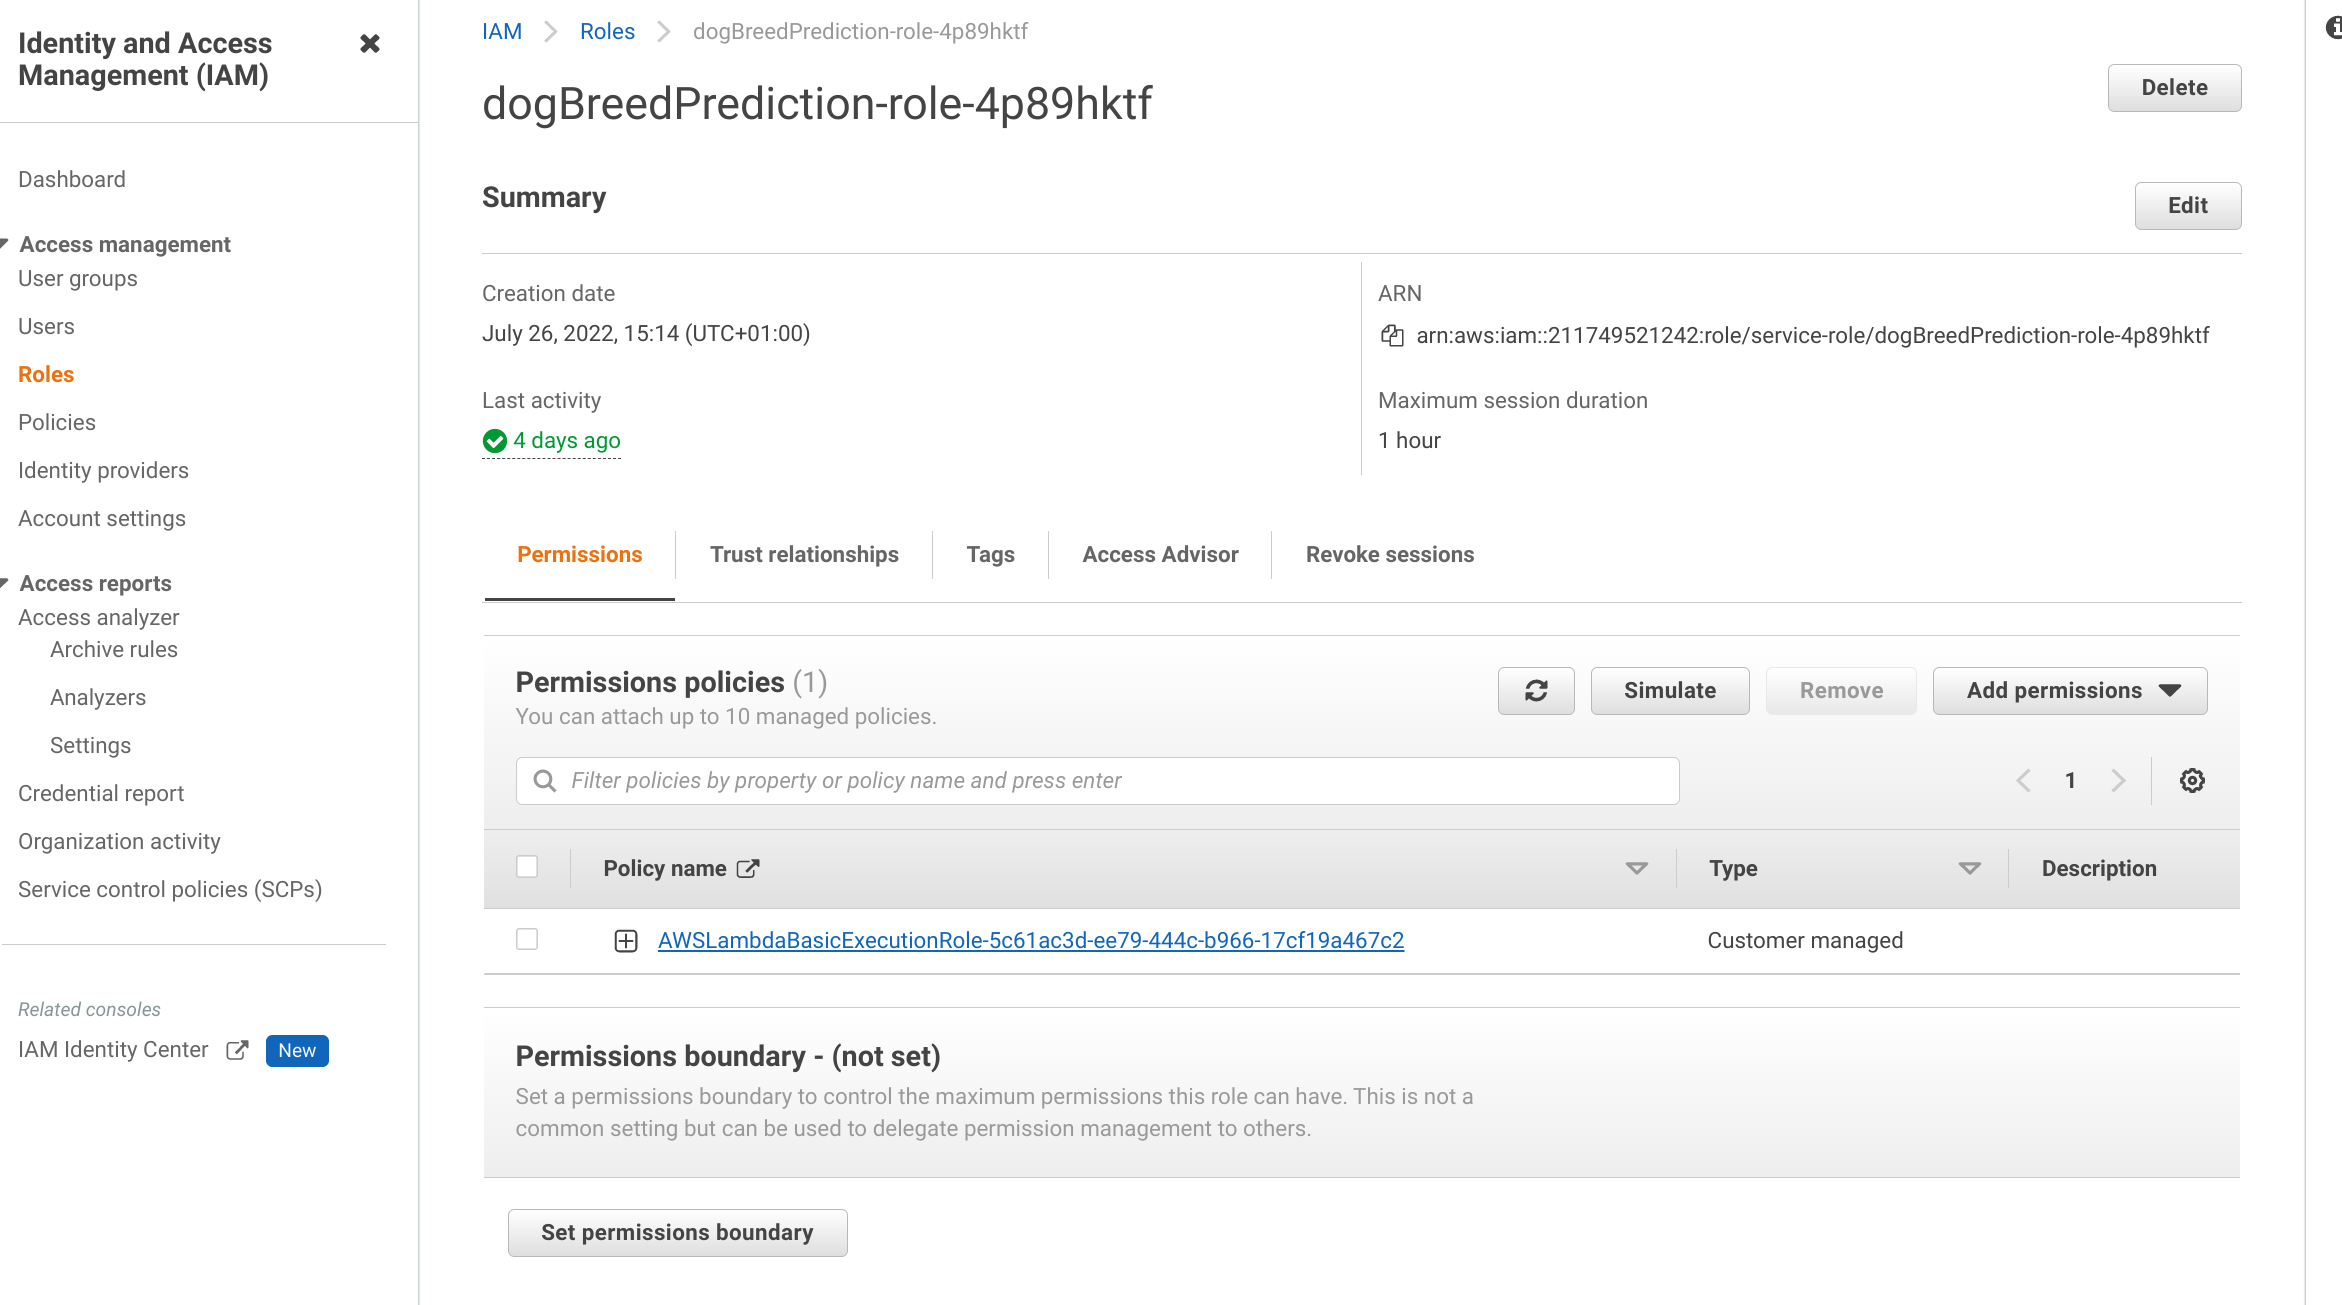

In [35]:
from IPython import display
display.Image("./screenshots/lambda-execution-role.png")

#### Policy with specific resource

Rather than adding a role to the lambda execution role, I added the explicit action required, namely sagemaker:InvokeEndpoint. 

Additionally I'm only giving permission to invoke the specific endpoint by changing the Resource property from "*" to the arn of the specific endpoint, namely "arn:aws:sagemaker:us-east-1:211749521242:endpoint/pytorch-inference-2022-07-31-08-08-01-157"



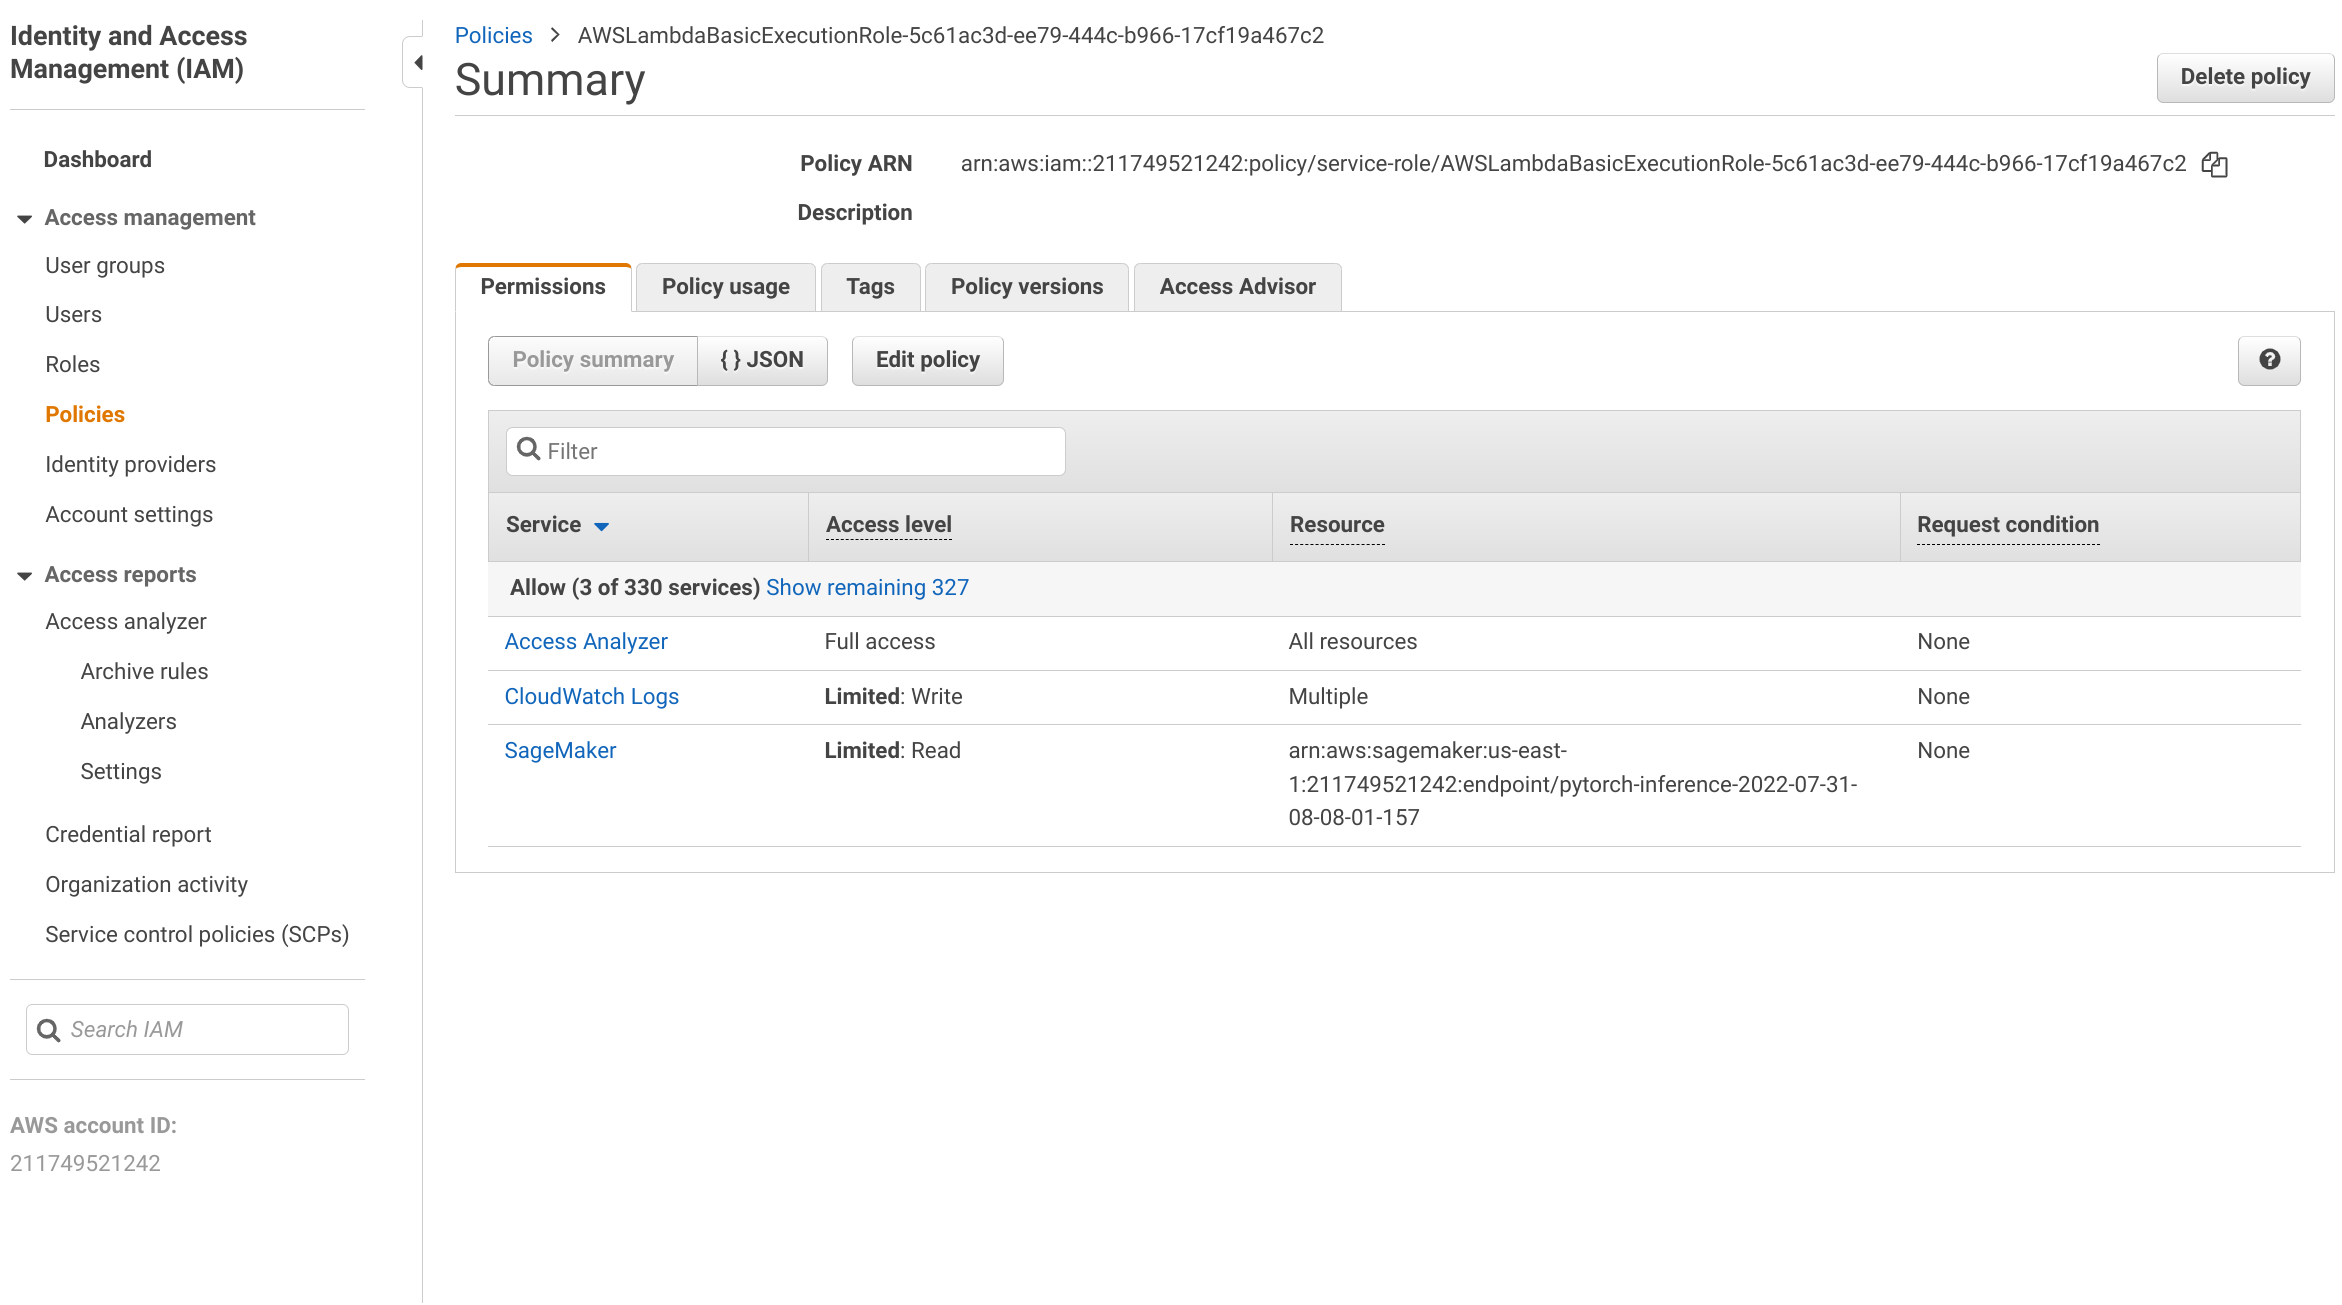

In [36]:
from IPython import display
display.Image("./screenshots/lambda-role-summary.png")


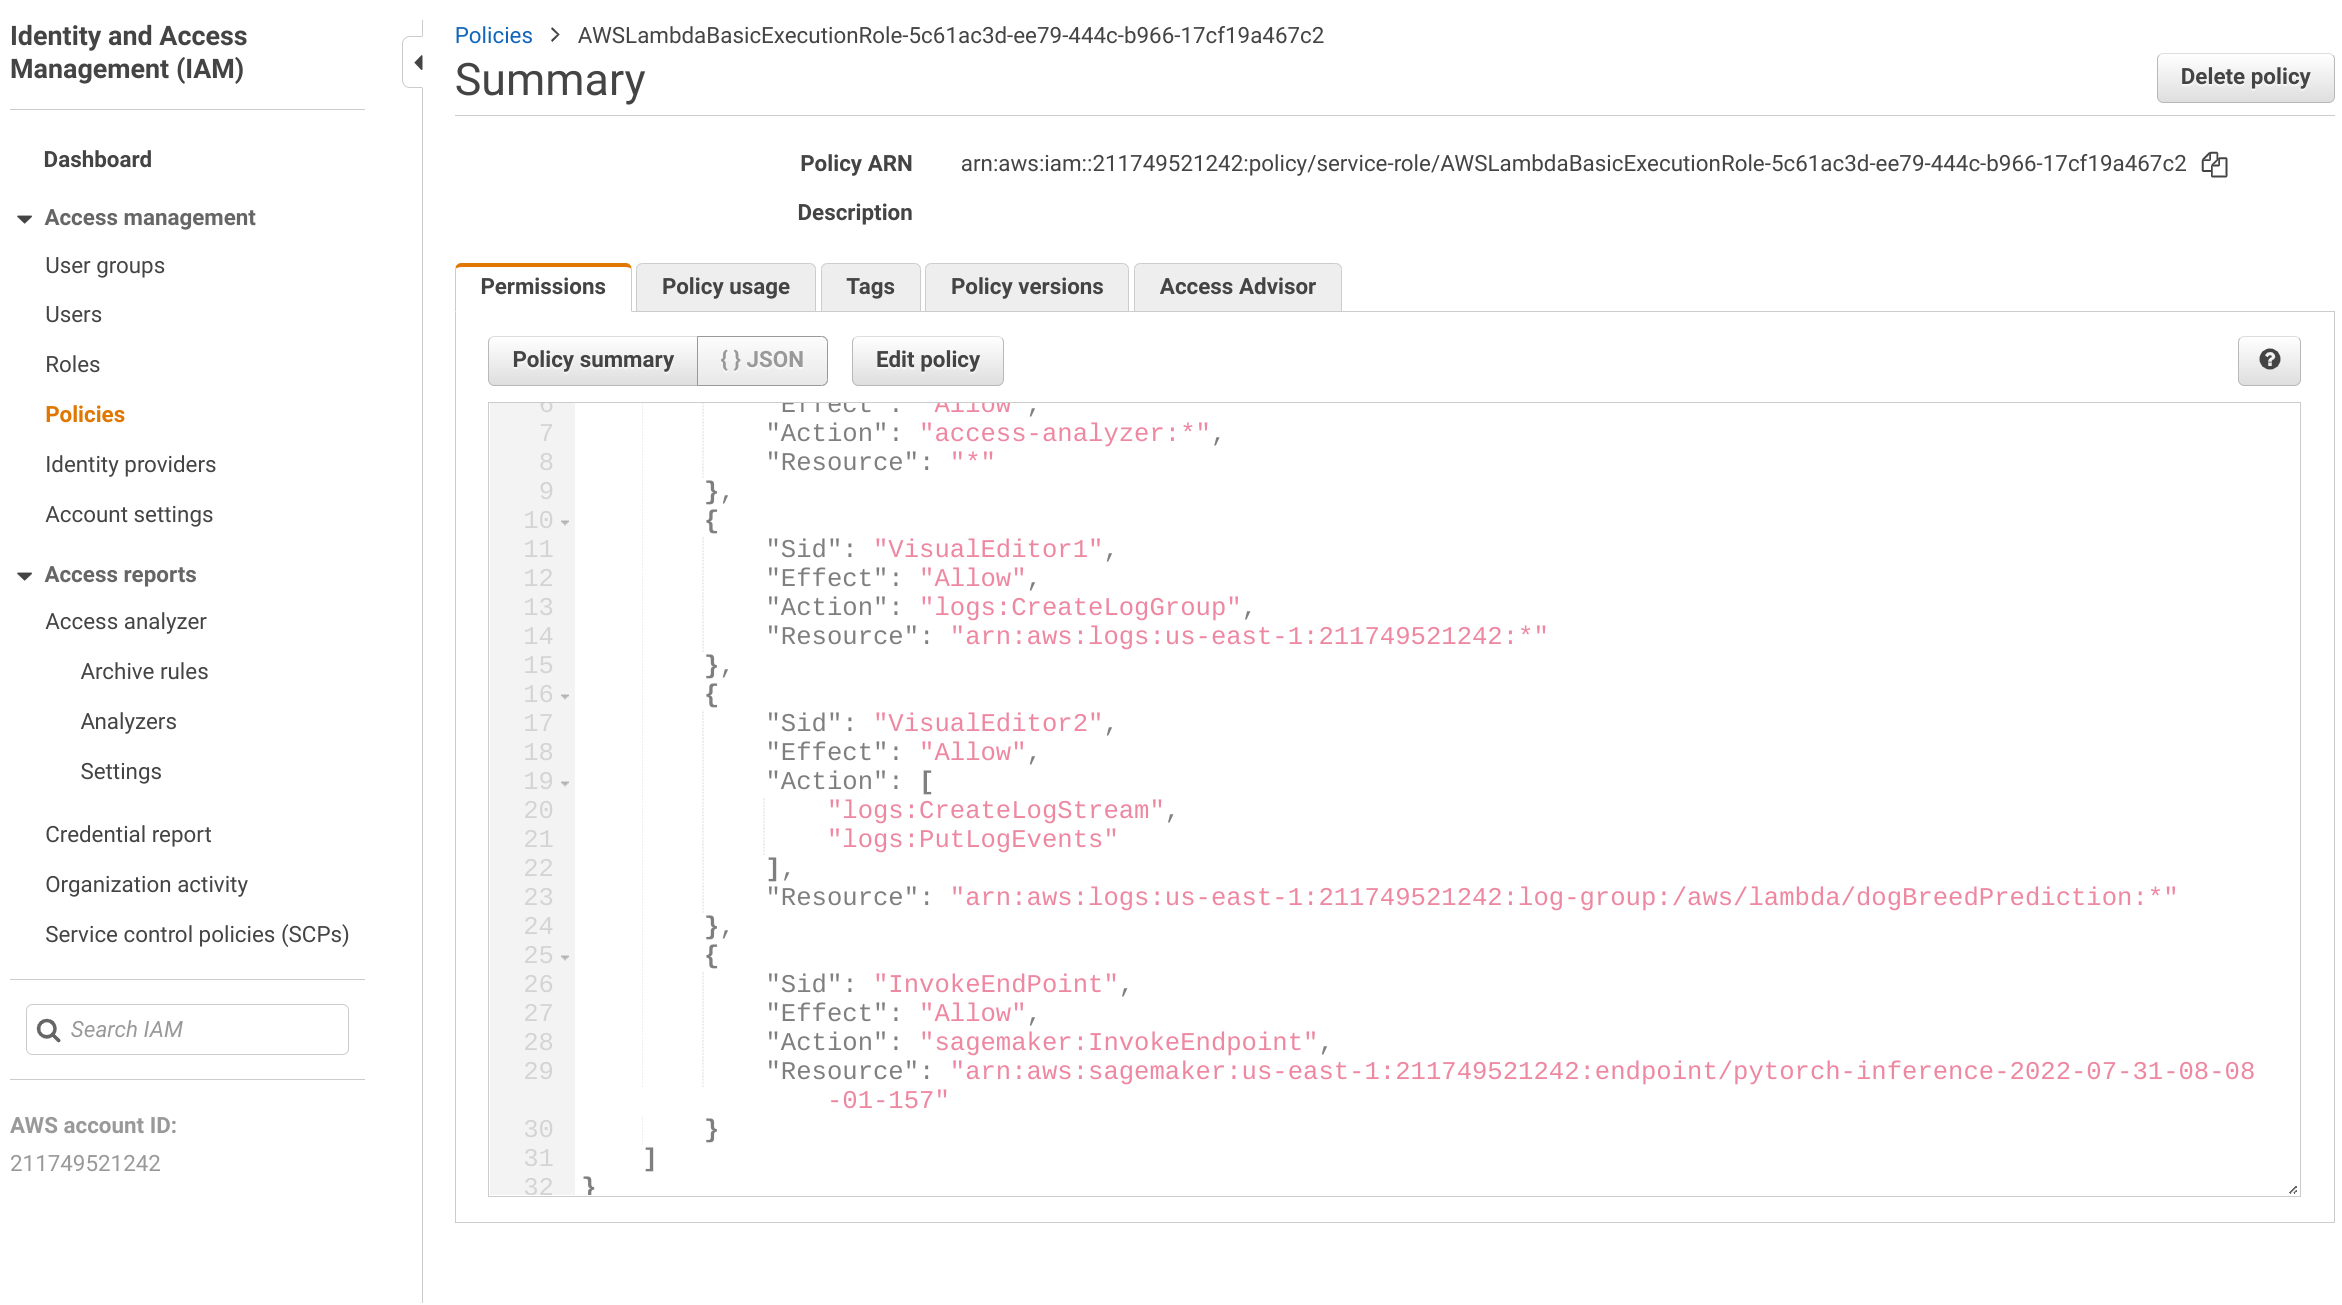

In [37]:
from IPython import display
display.Image("./screenshots/lambda-policy-specific-endpoint.png")

In [39]:
policy_single_resource = { "Version": "2012-10-17", "Statement": [ { "Sid": "VisualEditor0", "Effect": "Allow", "Action": "access-analyzer:", "Resource": "" }, { "Sid": "VisualEditor1", "Effect": "Allow", "Action": "logs:CreateLogGroup", "Resource": "arn:aws:logs:us-east-1:211749521242:" }, { "Sid": "VisualEditor2", "Effect": "Allow", "Action": [ "logs:CreateLogStream", "logs:PutLogEvents" ], "Resource": "arn:aws:logs:us-east-1:211749521242:log-group:/aws/lambda/dogBreedPrediction:" }, { "Sid": "InvokeEndPoint", "Effect": "Allow", "Action": "sagemaker:InvokeEndpoint", "Resource": "arn:aws:sagemaker:us-east-1:211749521242:endpoint/pytorch-inference-2022-07-31-08-08-01-157" } ] }

print(json.dumps(policy_single_resource, indent=2))

{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "VisualEditor0",
      "Effect": "Allow",
      "Action": "access-analyzer:",
      "Resource": ""
    },
    {
      "Sid": "VisualEditor1",
      "Effect": "Allow",
      "Action": "logs:CreateLogGroup",
      "Resource": "arn:aws:logs:us-east-1:211749521242:"
    },
    {
      "Sid": "VisualEditor2",
      "Effect": "Allow",
      "Action": [
        "logs:CreateLogStream",
        "logs:PutLogEvents"
      ],
      "Resource": "arn:aws:logs:us-east-1:211749521242:log-group:/aws/lambda/dogBreedPrediction:"
    },
    {
      "Sid": "InvokeEndPoint",
      "Effect": "Allow",
      "Action": "sagemaker:InvokeEndpoint",
      "Resource": "arn:aws:sagemaker:us-east-1:211749521242:endpoint/pytorch-inference-2022-07-31-08-08-01-157"
    }
  ]
}


### Other security considerations

In addition to securing the lambda function there are one or two other things that could be considered.


#### Create Multi Factor Authentication for root user

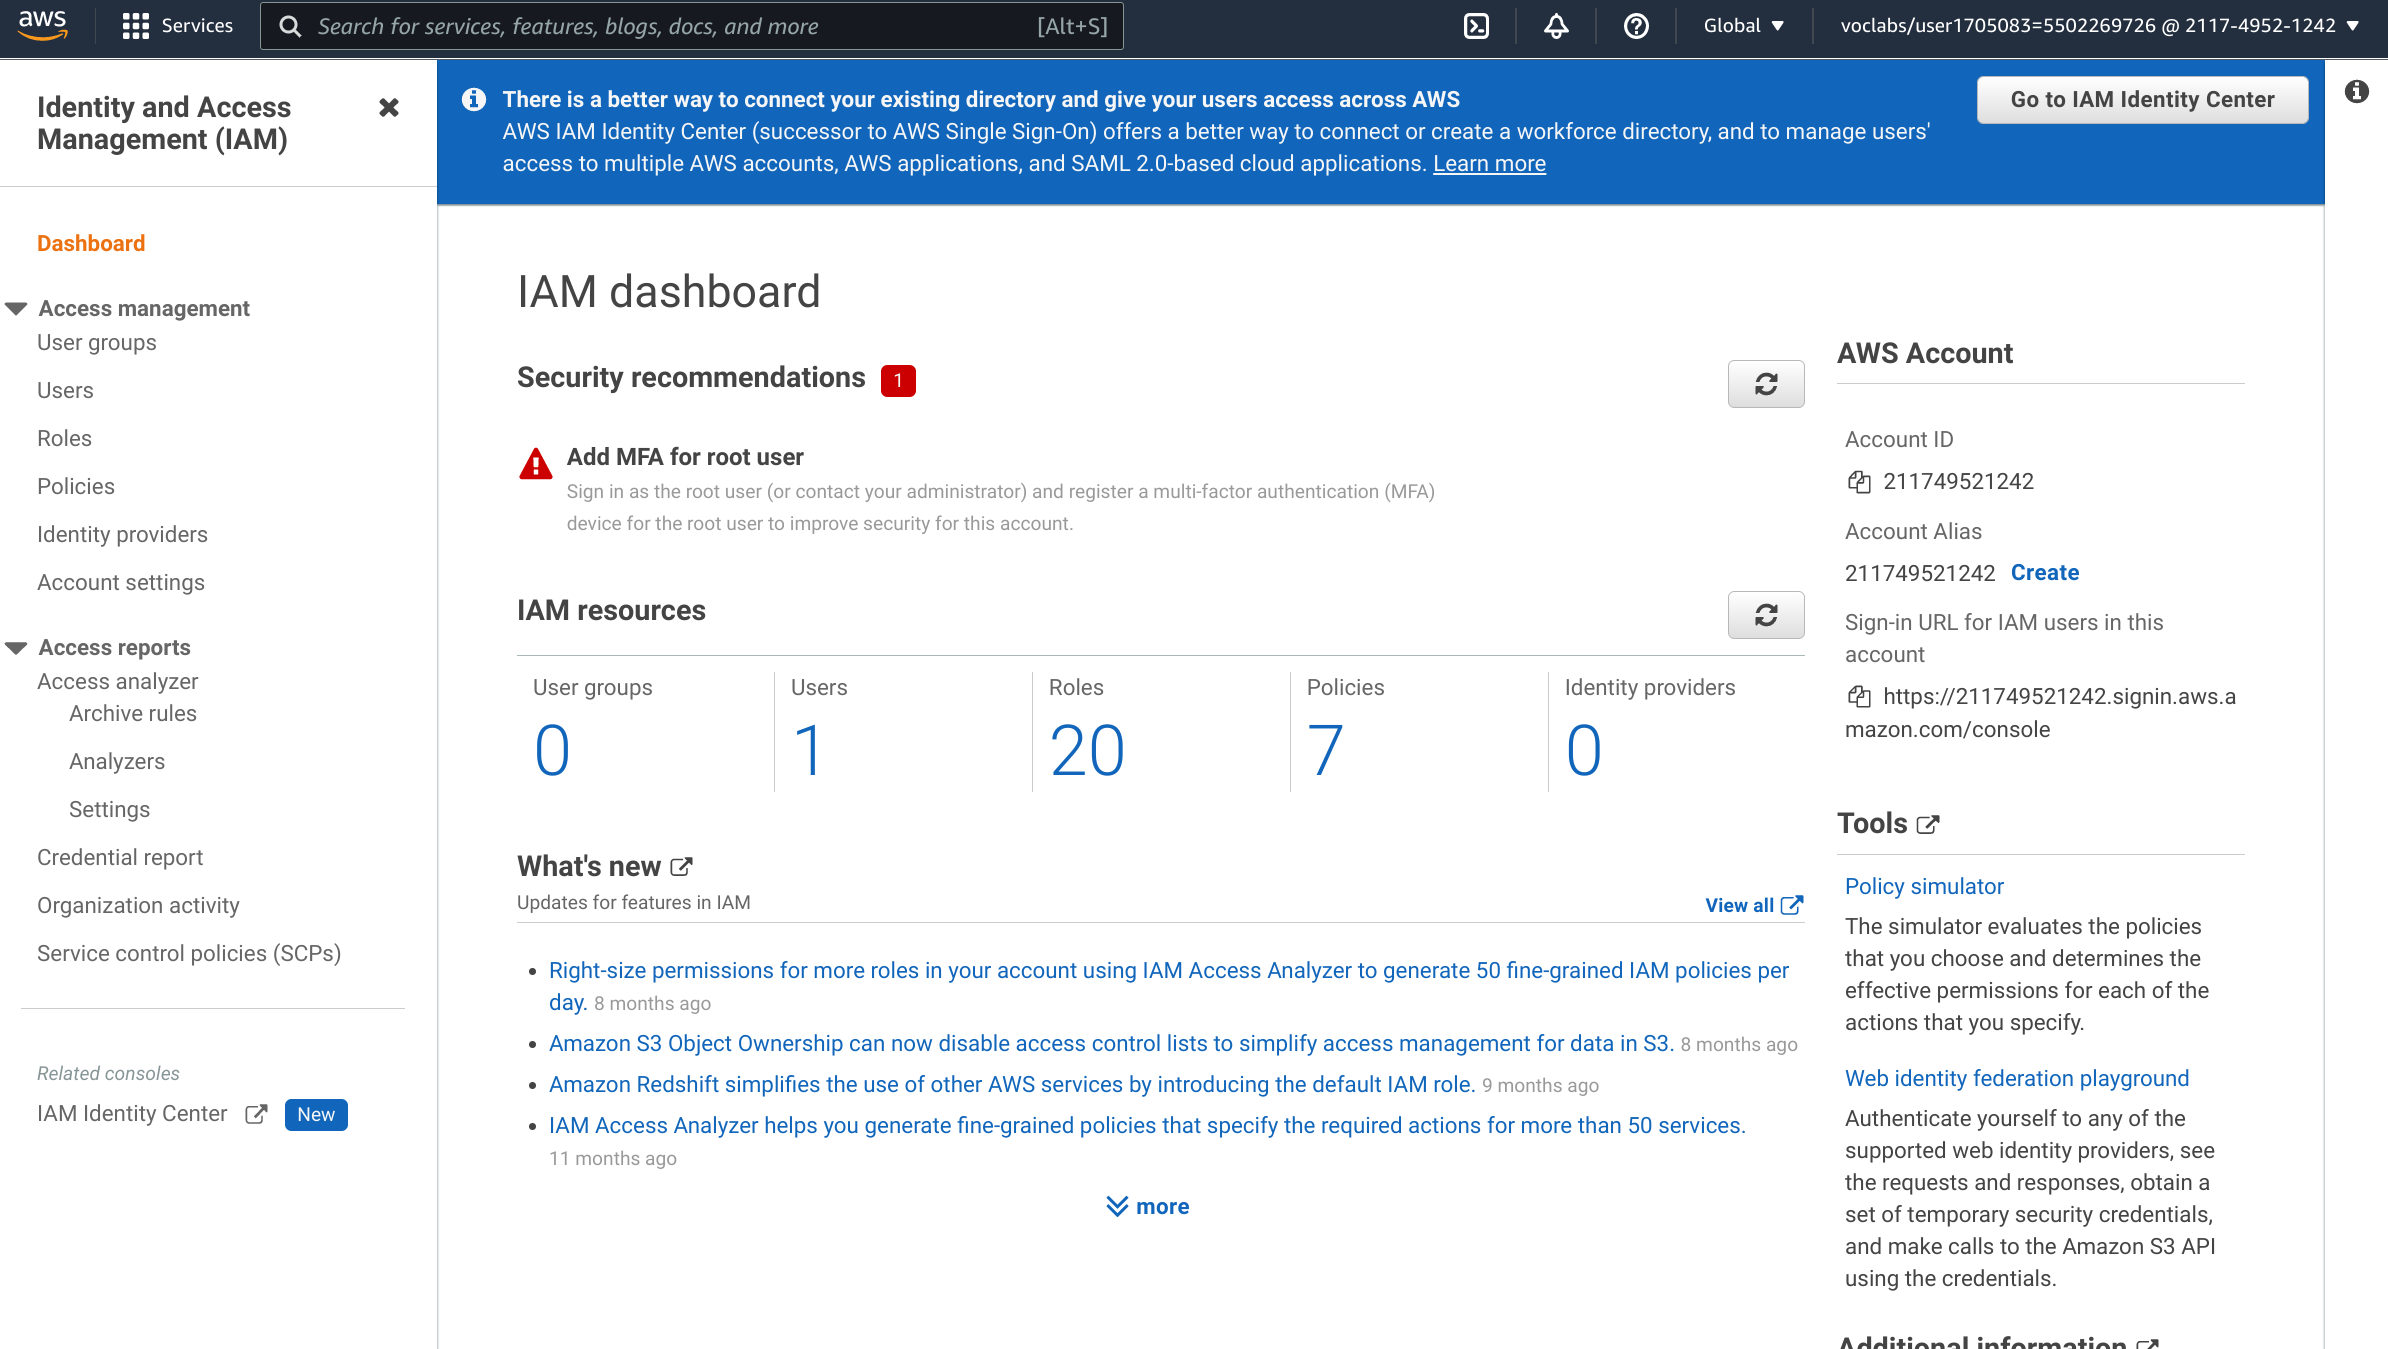

In [40]:
from IPython import display
display.Image("./screenshots/aws-iam-dashboard.png")

#### Creating users

It is generally good practise to define users in AWS rather than using the root user. Here I've done this to give myself programmatic access so that I can access AWS resource locally

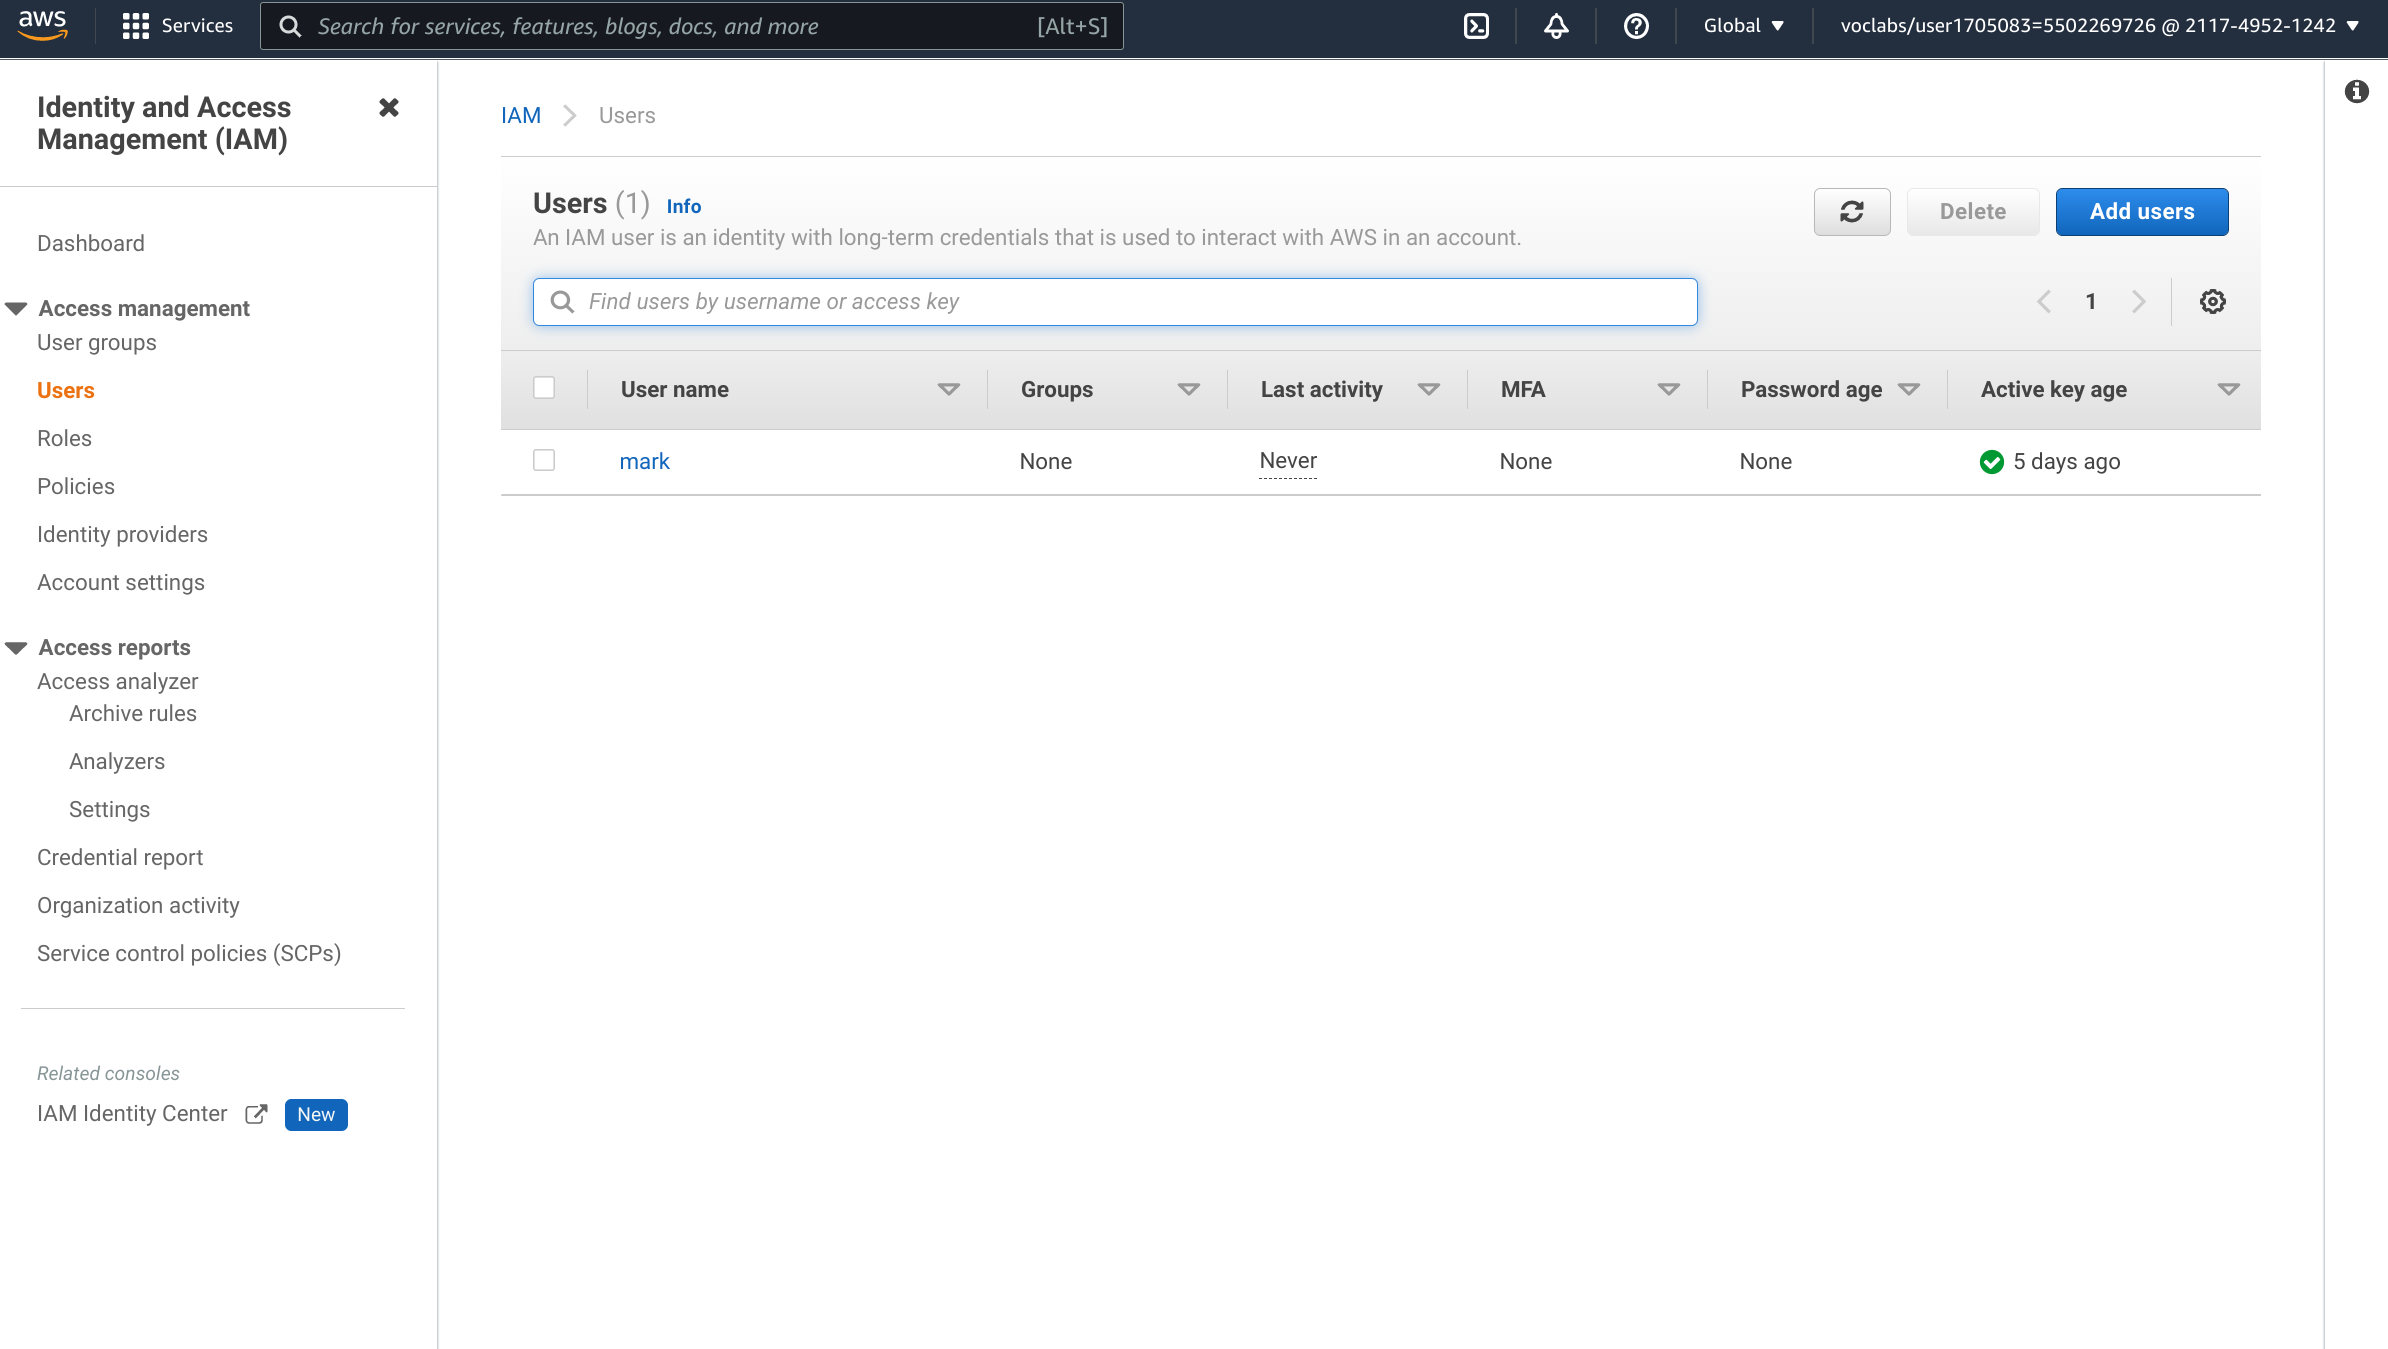

In [41]:
from IPython import display
display.Image("./screenshots/aws-iam-user.png")


#### Securing SageMaker notebook instances

By default SageMaker hosted notebook instances are accessible to anyone who has access to the AWS account. These could be made more secure by running in a subnet, in a VPC and applying more restrictive access rules in the security group associated.  